In [3]:
import os
import pandas as pd

# Define folder paths for different breathing patterns
folder_paths = {
    "Normal_Breathing":  "C:\\Users\\ADWIN ADI\\Downloads\\DSCE_Breathing_DataSets-main\\DSCE_Breathing_DataSets-main\\Breathing_Data\\Normal_Breathing",
    "Recovery_Breathing": "C:\\Users\\ADWIN ADI\\Downloads\\DSCE_Breathing_DataSets-main\\DSCE_Breathing_DataSets-main\\Breathing_Data\\Recovery_Breathing",
    "Endurance_Breathing": "C:\\Users\\ADWIN ADI\\Downloads\\DSCE_Breathing_DataSets-main\\DSCE_Breathing_DataSets-main\\Breathing_Data\\Endurance_Breathing",
}

# Define the base folder where cleaned data will be stored
base_cleaned_data_folder = "C:\\Users\\ADWIN ADI\\Downloads\\Cleaned_Data"

# Ensure the main cleaned data folder exists
os.makedirs(base_cleaned_data_folder, exist_ok=True)

# Function to remove outliers using the IQR method
def remove_outliers_iqr(df):
    total_outliers_removed = 0
    numeric_cols = df.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detect outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        total_outliers_removed += len(outliers)

        # Remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df, total_outliers_removed

# Process files for each breathing pattern
for breathing_type, folder_path in folder_paths.items():
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue

    # Create a subfolder inside Cleaned_Data for each breathing type
    breathing_cleaned_folder = os.path.join(base_cleaned_data_folder, breathing_type)
    os.makedirs(breathing_cleaned_folder, exist_ok=True)

    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path).dropna().reset_index(drop=True)

        # Remove outliers
        df_cleaned, total_outliers_removed = remove_outliers_iqr(df)

        # Save cleaned data
        cleaned_file_path = os.path.join(breathing_cleaned_folder, f"cleaned_{file}")
        df_cleaned.to_csv(cleaned_file_path, index=False)

        print(f"Processed {file} ({breathing_type}): {total_outliers_removed} outliers removed. Saved to {cleaned_file_path}")


Processed Ashvin_5Mins_NB_20_02_2025.csv (Normal_Breathing): 891 outliers removed. Saved to C:\Users\ADWIN ADI\Downloads\Cleaned_Data\Normal_Breathing\cleaned_Ashvin_5Mins_NB_20_02_2025.csv
Processed Harsha_5min_NB_20_02_25.csv (Normal_Breathing): 643 outliers removed. Saved to C:\Users\ADWIN ADI\Downloads\Cleaned_Data\Normal_Breathing\cleaned_Harsha_5min_NB_20_02_25.csv
Processed Manushree_5min_NB_19_02_2025.csv (Normal_Breathing): 216 outliers removed. Saved to C:\Users\ADWIN ADI\Downloads\Cleaned_Data\Normal_Breathing\cleaned_Manushree_5min_NB_19_02_2025.csv
Processed rakshita_5min_NB_10_02_2025.csv (Normal_Breathing): 154 outliers removed. Saved to C:\Users\ADWIN ADI\Downloads\Cleaned_Data\Normal_Breathing\cleaned_rakshita_5min_NB_10_02_2025.csv
Processed rakshitha AM_5min_NB_19_02.csv (Normal_Breathing): 252 outliers removed. Saved to C:\Users\ADWIN ADI\Downloads\Cleaned_Data\Normal_Breathing\cleaned_rakshitha AM_5min_NB_19_02.csv
Processed Sammita_5min_NB_19_02_2025.csv (Normal_B

In [10]:
import os
import numpy as np
import pandas as pd

# Define paths
cleaned_data_path = "C:\\Users\\ADWIN ADI\\Downloads\\Cleaned_Data"
segmented_data_path = "C:\\Users\\ADWIN ADI\\Downloads\\Segmented_Data"
data_folders = {
    "Normal_Breathing_60mins": 697,
    "Recovery_Breathing_22mins": 573,
    "Endurance_Breathing_17mins": 620
}

# Create segmented data directory
os.makedirs(segmented_data_path, exist_ok=True)

# Function to segment data based on provided samples per segment
def segment_and_save_data():
    for folder, samples_per_segment in data_folders.items():
        folder_path = os.path.join(cleaned_data_path, folder)
        segmented_folder_path = os.path.join(segmented_data_path, folder)
        os.makedirs(segmented_folder_path, exist_ok=True)
        
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                file_path = os.path.join(folder_path, file)
                df = pd.read_csv(file_path).dropna().reset_index(drop=True)
                
                # Determine number of segments
                num_segments = len(df) // samples_per_segment
                
                for i in range(num_segments):
                    segment = df.iloc[i * samples_per_segment : (i + 1) * samples_per_segment]
                    
                    # Save segmented file
                    segment_file = f"{file.replace('.csv', '')}_seg_{i+1}.csv"
                    segment.to_csv(os.path.join(segmented_folder_path, segment_file), index=False)
    
    print(f"Segmentation Completed! All files are saved in '{segmented_data_path}'.")

# Call segmentation function
segment_and_save_data()


Segmentation Completed! All files are saved in 'C:\Users\ADWIN ADI\Downloads\Segmented_Data'.


In [42]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [43]:
# Set path for segmented datasets (Update the path accordingly)
data_path = "C://Users//ADWIN ADI//Downloads//Segmented_Data"

In [44]:
# Define classes for multi-class classification
label_map = {
    "Normal_Breathing_60mins": 0,
    "Recovery_Breathing_22mins": 1,
    "Endurance_Breathing_17mins": 2
}

In [45]:
# Load dataset function
def load_data():
    X, y = [], []
    
    for folder, label in label_map.items():
        folder_path = os.path.join(data_path, folder)
        
        if not os.path.exists(folder_path):
            print(f"Warning: Folder '{folder}' not found. Skipping...")
            continue
        
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(folder_path, file))
                segment = df.values
                
                if len(segment) == 0:
                    continue  # Skip empty files
                
                X.append(segment)
                y.append(label)
    
    return np.array(X, dtype=object), np.array(y)

X, y = load_data()

In [46]:
# Determine max sequence length for padding/truncation
max_len = max(len(seq) for seq in X)


In [47]:
# Pad/truncate sequences to the same length
X_padded = np.array([np.pad(seq, ((0, max_len - len(seq)), (0, 0)), mode='constant') if len(seq) < max_len else seq[:max_len] for seq in X])


In [48]:
# Convert lists to NumPy arrays
X = np.array(X_padded)
y = np.array(y)

In [49]:
# Split dataset into Train (80%) / Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [50]:
# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [51]:
# Build Simple RNN Model
model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(32),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3-class classification
])

In [52]:
# Compile Model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [53]:
# Print Model Summary
model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_30 (SimpleRNN)   (None, 697, 128)          17280     
                                                                 
 simple_rnn_31 (SimpleRNN)   (None, 697, 64)           12352     
                                                                 
 simple_rnn_32 (SimpleRNN)   (None, 32)                3104      
                                                                 
 flatten_6 (Flatten)         (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 512)               16896     
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 3)               

In [54]:
# Train the Simple RNN model
history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=30, batch_size=32, verbose=1)


Epoch 1/30
4/4 [==============================] - 4s 483ms/step - loss: 0.9051 - accuracy: 0.6316 - val_loss: 0.5331 - val_accuracy: 0.8621
Epoch 2/30
4/4 [==============================] - 1s 374ms/step - loss: 0.5165 - accuracy: 0.8509 - val_loss: 0.6026 - val_accuracy: 0.6207
Epoch 3/30
4/4 [==============================] - 1s 357ms/step - loss: 0.4933 - accuracy: 0.7632 - val_loss: 0.3679 - val_accuracy: 0.7586
Epoch 4/30
4/4 [==============================] - 1s 358ms/step - loss: 0.3634 - accuracy: 0.8246 - val_loss: 0.1545 - val_accuracy: 1.0000
Epoch 5/30
4/4 [==============================] - 1s 340ms/step - loss: 0.2130 - accuracy: 0.9298 - val_loss: 0.1010 - val_accuracy: 1.0000
Epoch 6/30
4/4 [==============================] - 1s 340ms/step - loss: 0.2479 - accuracy: 0.8860 - val_loss: 0.0806 - val_accuracy: 1.0000
Epoch 7/30
4/4 [==============================] - 1s 345ms/step - loss: 0.0775 - accuracy: 1.0000 - val_loss: 0.0767 - val_accuracy: 1.0000
Epoch 8/30
4/4 [====

In [55]:
# Save the trained model
model.save("C:/Users/ADWIN ADI/Downloads/SimpleRNN_Breathing_Model.h5")


In [56]:
# Evaluate Model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

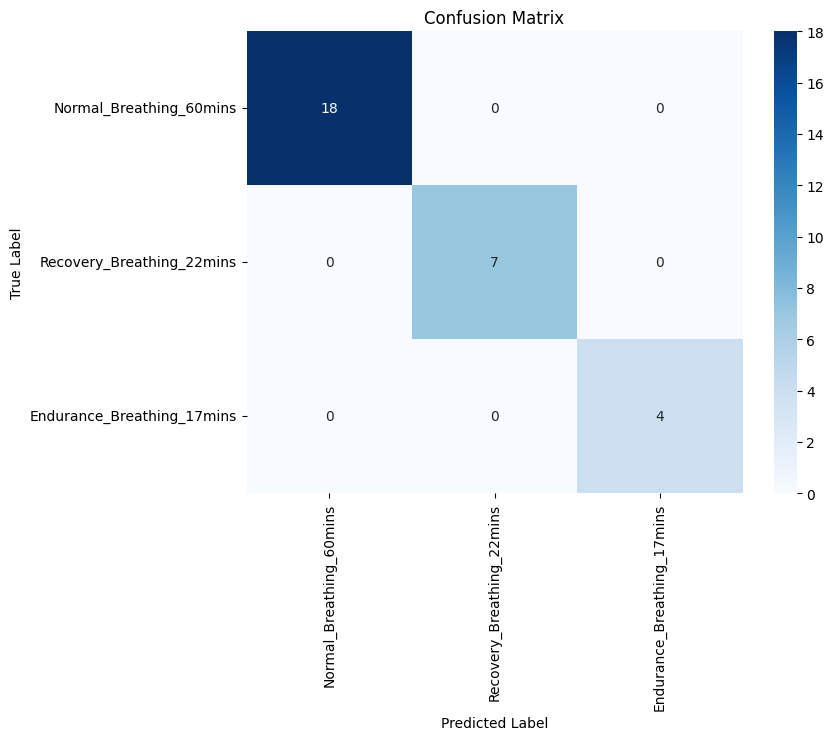

In [57]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [58]:
# Classification Report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=label_map.keys()))


Classification Report:
                             precision    recall  f1-score   support

   Normal_Breathing_60mins       1.00      1.00      1.00        18
 Recovery_Breathing_22mins       1.00      1.00      1.00         7
Endurance_Breathing_17mins       1.00      1.00      1.00         4

                  accuracy                           1.00        29
                 macro avg       1.00      1.00      1.00        29
              weighted avg       1.00      1.00      1.00        29



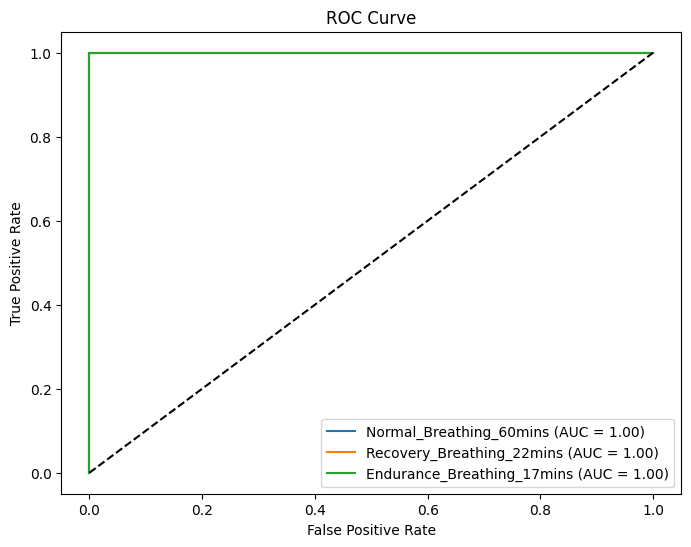

In [59]:
# ROC Curve for each class
plt.figure(figsize=(8,6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{list(label_map.keys())[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [75]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense, Masking
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
# Folder paths
folder_paths = {
    "Normal": "C:\\Users\\ADWIN ADI\\Downloads\\Normal_Breathing_60mins_segmented",
    "Recovery": "C:\\Users\\ADWIN ADI\\Downloads\\Recovery_Breathing_22mins_segmented",
    "Endurance": "C:\\Users\\ADWIN ADI\\Downloads\\Endurance_Breathing_17mins_segmented"
}


In [77]:
# Load data function
def load_data():
    X, y = [], []
    class_counts = {}  # Dictionary to store class counts
    for label, folder in folder_paths.items():
        if not os.path.exists(folder):
            print(f"Warning: Folder '{folder}' does not exist.")
            continue
        count = 0
        for file in os.listdir(folder):
            if file.endswith(".csv"):  # Ensure it's a CSV file
                file_path = os.path.join(folder, file)
                df = pd.read_csv(file_path, header=None)  # Assuming no header
                for i in range(len(df)):
                    X.append(df.iloc[i].values)
                    y.append(label)
                    count += 1
        class_counts[label] = count  # Store number of samples for this class
    return np.array(X, dtype=object), np.array(y), class_counts


In [78]:
# Load data
X, y, class_counts = load_data()

# Print class distribution
print("\n--- Dataset Summary ---")
print("Found 3 classes with the following number of samples:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} samples")
print("----------------------\n")


--- Dataset Summary ---
Found 3 classes with the following number of samples:
Normal: 60719 samples
Recovery: 20090 samples
Endurance: 13041 samples
----------------------



In [79]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [80]:
# One-hot encode labels
y_onehot = OneHotEncoder(sparse_output=False).fit_transform(y_encoded.reshape(-1, 1))

# Convert to numeric and handle missing values
X = [pd.to_numeric(seq, errors='coerce') for seq in X]
X = [np.nan_to_num(seq) for seq in X]  # Replace NaN with 0

# Pad sequences to ensure equal length
max_seq_length = max(len(seq) for seq in X)
X_padded = np.array([np.pad(seq, (0, max_seq_length - len(seq)), mode='constant') for seq in X])

In [81]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_onehot, test_size=0.2, random_state=42)

# Reshape for RNN input
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build Simple RNN model
model = Sequential([
    Masking(mask_value=0, input_shape=(max_seq_length, 1)),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [82]:

# Print model summary
print("\n--- Model Summary ---")
model.summary()


--- Model Summary ---
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_4 (Masking)         (None, 6, 1)              0         
                                                                 
 simple_rnn_39 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                                 
 dense_39 (Dense)            (None, 3)                 99        
                                                                 
Total params: 6,403
Trainable params: 6,403
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Extract model parameters
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_variables])
total_params = trainable_params + non_trainable_params

In [84]:
# Create model table
model_table = pd.DataFrame(columns=["Layer Name", "Output Shape", "Trainable Params", "Non-Trainable Params"])

for layer in model.layers:
    layer_name = layer.__class__.__name__
    output_shape = layer.output_shape
    trainable_count = np.sum([np.prod(v.shape) for v in layer.trainable_variables])
    non_trainable_count = np.sum([np.prod(v.shape) for v in layer.non_trainable_variables])

    # Append row to DataFrame
    model_table.loc[len(model_table)] = [layer_name, output_shape, trainable_count, non_trainable_count]

# Print model table
print("\n--- Model Parameters ---")
print(model_table.to_string(index=False))
print(f"\nTotal Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")
print("----------------------\n")

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test))


--- Model Parameters ---
Layer Name Output Shape  Trainable Params  Non-Trainable Params
   Masking (None, 6, 1)               0.0                   0.0
 SimpleRNN   (None, 64)            4224.0                   0.0
     Dense   (None, 32)            2080.0                   0.0
     Dense    (None, 3)              99.0                   0.0

Total Parameters: 6403.0
Trainable Parameters: 6403
Non-Trainable Parameters: 0.0
----------------------

Epoch 1/20
2347/2347 [==============================] - 8s 3ms/step - loss: 0.8604 - accuracy: 0.6438 - val_loss: 0.8410 - val_accuracy: 0.6511
Epoch 2/20
2347/2347 [==============================] - 6s 3ms/step - loss: 0.8513 - accuracy: 0.6457 - val_loss: 0.8328 - val_accuracy: 0.6511
Epoch 3/20
2347/2347 [==============================] - 6s 3ms/step - loss: 0.8489 - accuracy: 0.6459 - val_loss: 0.8407 - val_accuracy: 0.6511
Epoch 4/20
2347/2347 [==============================] - 7s 3ms/step - loss: 0.8470 - accuracy: 0.6459 - val_loss: 0

In [85]:
# Save model in Downloads folder
downloads_folder = os.path.expanduser("~/Downloads")
model_path = os.path.join(downloads_folder, "breathing_pattern_rnn.h5")
model.save(model_path)
print(f"Model saved successfully at: {model_path}")

# Model Evaluation
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Model saved successfully at: C:\Users\ADWIN ADI/Downloads\breathing_pattern_rnn.h5


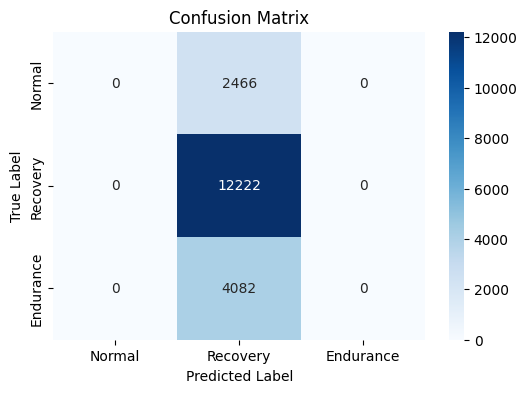

Total Samples in Test Set: 18770
Total Predictions in Confusion Matrix: 18770
Actual Counts in Test Set: [ 2466 12222  4082]
Row-wise Sum in Confusion Matrix: [ 2466 12222  4082]
Match Status: True
True: Recovery, Predicted: Normal
True: Normal, Predicted: Normal
True: Normal, Predicted: Normal
True: Normal, Predicted: Normal
True: Recovery, Predicted: Normal
True: Recovery, Predicted: Normal
True: Normal, Predicted: Normal
True: Normal, Predicted: Normal
True: Endurance, Predicted: Normal
True: Normal, Predicted: Normal
Sample Predictions Probabilities: [1.0000001  1.         1.         1.         1.         0.99999994
 1.         1.         1.         0.99999994]
Total Misclassified Samples: 6548


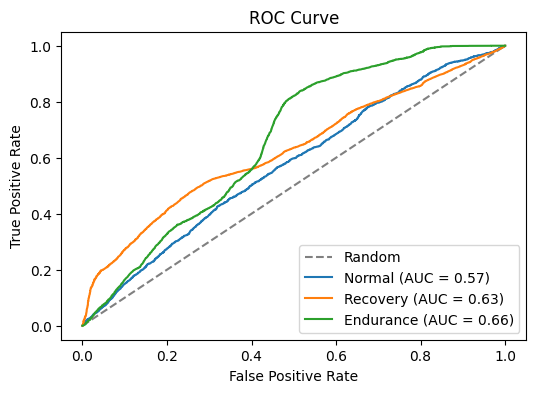

              precision    recall  f1-score   support

      Normal       1.00      0.00      0.00      2466
    Recovery       0.65      1.00      0.79     12222
   Endurance       1.00      0.00      0.00      4082

    accuracy                           0.65     18770
   macro avg       0.88      0.33      0.26     18770
weighted avg       0.77      0.65      0.51     18770



In [89]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=folder_paths.keys(), yticklabels=folder_paths.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Verify Confusion Matrix Correctness
print("Total Samples in Test Set:", len(y_test))
print("Total Predictions in Confusion Matrix:", np.sum(conf_matrix))

actual_counts = np.bincount(y_true_classes, minlength=len(folder_paths))
predicted_counts = np.sum(conf_matrix, axis=1)  # Row sum (actual class count in matrix)

print("Actual Counts in Test Set:", actual_counts)
print("Row-wise Sum in Confusion Matrix:", predicted_counts)
print("Match Status:", np.array_equal(actual_counts, predicted_counts))

for i in range(10):  # Check first 10 samples
    print(f"True: {label_encoder.inverse_transform([y_true_classes[i]])[0]}, Predicted: {label_encoder.inverse_transform([y_pred_classes[i]])[0]}")

print("Sample Predictions Probabilities:", np.sum(y_pred, axis=1)[:10])  # Should be close to 1

misclassified = np.where(y_true_classes != y_pred_classes)[0]
print(f"Total Misclassified Samples: {len(misclassified)}")

# ROC Curve
plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')  # Gray random line
for i, label in enumerate(folder_paths.keys()):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Classification Report (Fix UndefinedMetricWarning)
print(classification_report(y_true_classes, y_pred_classes, target_names=folder_paths.keys(), zero_division=1))

# Load model for future inference
loaded_model = load_model("breathing_pattern_rnn.h5")